In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 100)

#显示所有行

pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import warnings
import feather
warnings.filterwarnings("ignore")
import math
sys.path.append('/data/apps/modules/jupyter')
from helper.spark_helper import *
from helper.presto_helper import query_presto
from helper.csv_helper import *
from helper.pandas_helper import *
from helper.presto_helper import query_hive_wy

In [ ]:
# dim.dim_user_info_df       用户维度信息表
# dws.dws_pt_user_action_da  用户活跃情况
# dws.dws_pt_user_picture_da 用户画像表    统计数据不准确
# iaudience.csv              极光用户画像

In [2]:
#citys = ','.join([str(i) for i in [196,155,231,132,357,83,377,179,269,87,153,247,295,373,320,332,376,227,223,195,404,503,471]])
citys='196'
features = get_df_from_csv_table(query_presto(f'''
    select a.user_id, a.city_id, a.birthday, a.gender, b.model, b.brand, b.sys_ver,a.mobile
    from
    (select user_id, city_id, birthday, gender, mobile
    from dim.dim_user_info_df
    where city_id in ({citys})
    and gender!=0
    and birthday is not null
    and event_day='20210328') a left join
    (select user_id, model, brand, sys_ver
    from dws.dws_pt_user_action_da
    where event_day='20210328') b on a.user_id=b.user_id
'''))


In [3]:
orders = get_df_from_csv_table(query_presto(f'''
    select user_id, cur_date, order_count_d, order_count_t
    from dws.dws_pt_user_picture_da
    where city_id in ({citys})
''')).dropna()

In [393]:
orders2 = get_df_from_csv_table(query_presto(f'''
    select user_id, cur_date, order_days_30d
    from dws.dws_pt_user_picture_da
    where city_id in ({citys})
''')).dropna()

In [4]:
jiguang_df=pd.read_csv('iaudience.csv')

In [5]:
jiguang_df=jiguang_df.rename({'imei/phone/mac/imsi':'mobile'},axis=1)
jiguang_df.head()

,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,CAR_Part_LocViewScore,CAR_Rental_LocViewDateScore,CAR_Rental_LocViewScore,CAR_Repair_LocViewDateScore,CAR_Repair_LocViewScore,CAR_Sale_LocViewDateScore,CAR_Sale_LocViewScore,CAR_Service_LocViewDateScore,CAR_Service_LocViewScore,ALL_Home_Work_LocDistanceScore,ALL_Trip_LocViewDateScore,ALL_Trip_LocViewScore,EDU_Driving_LocViewDateScore,EDU_Driving_LocViewScore,EDU_Child_LocViewDateScore,EDU_Child_LocViewScore,EDU_Kindergarden_LocViewDateScore,EDU_Kindergarden_LocViewScore,EDU_Primary_LocViewDateScore,EDU_Primary_LocViewScore,EDU_Junior_LocViewDateScore,EDU_Junior_LocViewScore,EDU_Middle_LocViewDateScore,EDU_Middle_LocViewScore,EDU_Senior_LocViewDateScore,EDU_Senior_LocViewScore,EDU_Colleage_LocViewDateScore,EDU_Colleage_LocViewScore,EDU_Abroad_LocViewDateScore,EDU_Abroad_LocViewScore,EDU_Adult_LocViewDateScore,EDU_Adult_LocViewScore,EDU_Art_LocViewDateScore,EDU_Art_LocViewScore,EDU_Body_Building_LocViewDateScore,EDU_Body_Building_LocViewScore,EDU_Gourmand_LocViewDateScore,EDU_Gourmand_LocViewScore,EDU_Language_LocViewDateScore,EDU_Language_LocViewScore,EDU_Officeholder_LocViewDateScore,EDU_Officeholder_LocViewScore,EDU_Postgraduate_LocViewDateScore,EDU_Postgraduate_LocViewScore,HOUSE_Newhouse_LocViewDateScore,HOUSE_Newhouse_LocViewScore,TRAVEL_Travel_Agency_LocViewDateScore,TRAVEL_Travel_Agency_LocViewScore,TRAVEL_Travel_LocViewDateScore,TRAVEL_Travel_LocViewScore
0,18282870056,查询标签成功-有标签,有,M,已婚,中国,1.0,未知,R9,OPPO,cpu数:八核;cpu型号:联发科 MT6755;cpu主频:2.0GHZ;ram:未知;手...,中国移动,Android,2499.0,1920*1080,5.5英寸,2016年05月,手机,NaN,中,低,N,"大众,1.0",企业人员,听音乐&1、工作一族&1、户外休闲&1、精打细算&1、购物狂&1,计算器&1、阅读器&1、麻将棋牌&3、日历闹钟天气&2、兴趣社区&1、wifi网络&2、聊天...,"团购,0.5&网络商城,0.5",其它、转账支付、学习辅导、聊天交友、健身攻略、购物、听音乐、考试资料、地图查询、休闲,健身攻略、搜索查询、外文阅读、体育新闻、论坛微博,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13568652678,查询标签成功-有标签,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,中国移动,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13861134574,查询标签成功-无标签,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13981566579,查询标签成功-有标签,有,F,已婚,中国,1.0,孕育期,X7 PLUS,VIVO,cpu数:八核;cpu型号:高通 骁龙652（MSM8976）;cpu主频:1.8GHZ;r...,中国电信,Android,1270.0,1920*1080,5.7英寸,2016年07月23日,手机,NaN,NaN,NaN,图书专卖,"大众,1.0",企业人员,听音乐&1、工作一族&2、潮范儿&2、爱美食&1、看视频&4、社交达人&2、精打细算&3、购...,生活小工具&3、拍照P图&8、小说阅读&1、视频播放&4、便签记事&1、综合商城&2、wif...,"购物分享,0.25&团购,0.25&网络商城,0.5",其它

In [6]:
features['mobile']=features['mobile'].astype('int')
merge_df=pd.merge(jiguang_df,features,on='mobile',how='left')

In [7]:
orders.head()

,user_id,cur_date,order_count_d,order_count_t
1,3631330,2021-04-03 00:00:00.000,0.0,1.0
2,3640649,2021-04-03 00:00:00.000,0.0,65.0
3,4207947,2021-04-03 00:00:00.000,0.0,98.0
4,4306870,2021-04-03 00:00:00.000,0.0,267.0
5,4360261,2021-04-03 00:00:00.000,0.0,19.0


In [14]:
orders['cur_date'] = pd.to_datetime(orders['cur_date'])
orders['month'] = pd.DatetimeIndex(pd.to_datetime(orders['cur_date'])).month
orders['year'] = pd.DatetimeIndex(pd.to_datetime(orders['cur_date'])).year
orders['day'] = pd.DatetimeIndex(pd.to_datetime(orders['cur_date'])).day
orders['week'] = pd.DatetimeIndex(pd.to_datetime(orders['cur_date'])).week

In [15]:
print('orders,merge_df:',orders.shape,merge_df.shape)

orders,merge_df: (13903692, 8) (30132, 347)


In [21]:
# od: 每天订单最大值
od = orders.groupby(['user_id']).order_count_d.max().reset_index()
od = od[od.order_count_d>0]

In [22]:
# ow: 每周订单最大值
ow = orders.groupby(['user_id','week']).order_count_d.sum().reset_index()
ow = ow.groupby('user_id').order_count_d.max().reset_index()

In [23]:
od.head()

,user_id,order_count_d
13,1714167,2.0
14,1734281,1.0
15,1734498,1.0
16,1758254,2.0
17,1776258,1.0


###   历史30天 > 5单 偏好

In [394]:
od2=orders2.groupby(['user_id']).order_days_30d.max().reset_index()
od2 = od2[od2.order_days_30d>0]

In [398]:
od2['pref2'] = 1* (od2['order_days_30d']>5)
print('od2.shape:',od2.shape)
od2.head()

od2.shape: (64266, 4)


,user_id,order_days_30d,pref,pref2
4,1080596,3.0,0,0
13,1714167,5.0,0,0
14,1734281,1.0,0,0
15,1734498,1.0,0,0
16,1758254,7.0,1,1


In [397]:
od2[od2.pref==1].shape

(22681, 3)

In [399]:
train_df4 = pd.merge(train_df3,od2, on='user_id', how='left')

In [400]:
train_df4.shape

(24298, 706)

In [401]:
train_df4[train_df4.pref2==1].shape

(10049, 706)

In [466]:
orders3 = get_df_from_csv_table(query_presto(f'''
    select distinct(user_id), cur_date, order_days_30d,if(order_days_30d>5,1,0) as pref3
    from dws.dws_pt_user_picture_da
    where city_id in ({citys}) and event_day='20210406'
''')).dropna()

print(orders3.shape)
orders3.head()

(100918, 4)


,user_id,cur_date,order_days_30d,pref3
0,6612664,2021-04-06 00:00:00.000,0.0,0
1,6881571,2021-04-06 00:00:00.000,0.0,0
2,6930627,2021-04-06 00:00:00.000,0.0,0
3,6946919,2021-04-06 00:00:00.000,0.0,0
4,7045671,2021-04-06 00:00:00.000,7.0,1


In [431]:
orders3[orders3.pref3==1].shape

(14310, 4)

In [467]:
train_df6 = pd.merge(train_df3,orders3, on='user_id', how='left')
print(train_df6[train_df6.pref3==1].shape,train_df6.shape)

(3730, 706) (24298, 706)


In [459]:
train_df5['pref']=train_df5['pref'].fillna(0)

In [462]:
# # train_df5=train_df5.dropna()
# print(train_df5[train_df5.pref3==1].shape,train_df5[train_df5.pref3==0].shape,train_df5.shape)
# train_df5['pref3']=train_df5['pref3'].astype('int')
# train_df5.shape

In [27]:
# pref: 偏好
od['pref'] = 1* (od['order_count_d']>1)
print('od.shape:',od.shape)
od.head()

od.shape: (56013, 3)


,user_id,order_count_d,pref
13,1714167,2.0,1
14,1734281,1.0,0
15,1734498,1.0,0
16,1758254,2.0,1
17,1776258,1.0,0


In [28]:
temp = orders.groupby('user_id').agg({'order_count_d':'sum'})
temp = temp.reset_index()
train_list = temp[temp.order_count_d>0].user_id
test_list = temp[temp.order_count_d==0].user_id

In [39]:
train_df = pd.merge(merge_df,od[od.user_id.isin(train_list)], on='user_id', how='left')

In [37]:
import re
def edit_ver(x):
    try:
        if type(x)==type(0.1):
            return 'None'
        elif re.match('\d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+$', x):
            return x
        elif re.match('iOS \d+$', x):
            return x
        elif re.match('iOS\d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('iOS \d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('\d+$', x):
            return 'Android '+x
        else:
            return 'Other'
    except:
        print(type(x))

In [40]:
print('train_df:',train_df.shape)
train_df.head()

train_df: (30132, 349)


,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,ALL_Home_Work_LocDistanceScore,ALL_Trip_LocViewDateScore,ALL_Trip_LocViewScore,EDU_Driving_LocViewDateScore,EDU_Driving_LocViewScore,EDU_Child_LocViewDateScore,EDU_Child_LocViewScore,EDU_Kindergarden_LocViewDateScore,EDU_Kindergarden_LocViewScore,EDU_Primary_LocViewDateScore,EDU_Primary_LocViewScore,EDU_Junior_LocViewDateScore,EDU_Junior_LocViewScore,EDU_Middle_LocViewDateScore,EDU_Middle_LocViewScore,EDU_Senior_LocViewDateScore,EDU_Senior_LocViewScore,EDU_Colleage_LocViewDateScore,EDU_Colleage_LocViewScore,EDU_Abroad_LocViewDateScore,EDU_Abroad_LocViewScore,EDU_Adult_LocViewDateScore,EDU_Adult_LocViewScore,EDU_Art_LocViewDateScore,EDU_Art_LocViewScore,EDU_Body_Building_LocViewDateScore,EDU_Body_Building_LocViewScore,EDU_Gourmand_LocViewDateScore,EDU_Gourmand_LocViewScore,EDU_Language_LocViewDateScore,EDU_Language_LocViewScore,EDU_Officeholder_LocViewDateScore,EDU_Officeholder_LocViewScore,EDU_Postgraduate_LocViewDateScore,EDU_Postgraduate_LocViewScore,HOUSE_Newhouse_LocViewDateScore,HOUSE_Newhouse_LocViewScore,TRAVEL_Travel_Agency_LocViewDateScore,TRAVEL_Travel_Agency_LocViewScore,TRAVEL_Travel_LocViewDateScore,TRAVEL_Travel_LocViewScore,user_id,city_id,birthday,gender,model,brand,sys_ver,order_count_d,pref
0,18282870056,查询标签成功-有标签,有,M,已婚,中国,1.0,未知,R9,OPPO,cpu数:八核;cpu型号:联发科 MT6755;cpu主频:2.0GHZ;ram:未知;手...,中国移动,Android,2499.0,1920*1080,5.5英寸,2016年05月,手机,NaN,中,低,N,"大众,1.0",企业人员,听音乐&1、工作一族&1、户外休闲&1、精打细算&1、购物狂&1,计算器&1、阅读器&1、麻将棋牌&3、日历闹钟天气&2、兴趣社区&1、wifi网络&2、聊天...,"团购,0.5&网络商城,0.5",其它、转账支付、学习辅导、聊天交友、健身攻略、购物、听音乐、考试资料、地图查询、休闲,健身攻略、搜索查询、外文阅读、体育新闻、论坛微博,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9815458,196,1982-08-22 00:00:00.000,2,STK-AL00,HUAWEI,Android 10,4.0,1.0
1,13568652678,查询标签成功-有标签,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,中国移动,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20735127,196,1974-05-02 00:00:00.000,2,PBET00,OPPO,Android 10,2.0,1.0
2,13861134574,查询标签成功-无标签,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46771258,196,1997-12-10 00:00:00.000,2,V2002A,vivo,Android 10,2.0,1.0
3,13981566579,查询标签成功-有标签,有,F,已婚,中国,1.0,孕育期,X7 PLUS,VIVO,cpu数:八核;cpu型号:高通 骁龙652（MSM8976）;cpu主频:1.8GHZ;r...,中国电信,Android,1270.0,1920*1080,5.7英寸,2016年07月23日,手机,NaN,NaN,NaN,图书专卖,"大众,1.0",企业人员,听音乐&1、工作一族&2、潮范儿&2、爱美食&1、看视频&4、社交达人&2、精打细算&3、购...,生活小工具&3、拍照P图&8、小说阅读&1、视频播放&4、便签记事&1、综合商城&2、wif...,"购物分享,0.25&团购,0.25&网络商城,0.5",其它、聊天交友、看电影、购物、休闲、考试资料、转账支付、看新闻、订票酒店、地图查询,论坛微博、孕育知识、搜索

In [41]:
train_df.groupby('sys_ver').count().sort_values(by='brand',ascending=False)

,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,CAR_Service_LocViewScore,ALL_Home_Work_LocDistanceScore,ALL_Trip_LocViewDateScore,ALL_Trip_LocViewScore,EDU_Driving_LocViewDateScore,EDU_Driving_LocViewScore,EDU_Child_LocViewDateScore,EDU_Child_LocViewScore,EDU_Kindergarden_LocViewDateScore,EDU_Kindergarden_LocViewScore,EDU_Primary_LocViewDateScore,EDU_Primary_LocViewScore,EDU_Junior_LocViewDateScore,EDU_Junior_LocViewScore,EDU_Middle_LocViewDateScore,EDU_Middle_LocViewScore,EDU_Senior_LocViewDateScore,EDU_Senior_LocViewScore,EDU_Colleage_LocViewDateScore,EDU_Colleage_LocViewScore,EDU_Abroad_LocViewDateScore,EDU_Abroad_LocViewScore,EDU_Adult_LocViewDateScore,EDU_Adult_LocViewScore,EDU_Art_LocViewDateScore,EDU_Art_LocViewScore,EDU_Body_Building_LocViewDateScore,EDU_Body_Building_LocViewScore,EDU_Gourmand_LocViewDateScore,EDU_Gourmand_LocViewScore,EDU_Language_LocViewDateScore,EDU_Language_LocViewScore,EDU_Officeholder_LocViewDateScore,EDU_Officeholder_LocViewScore,EDU_Postgraduate_LocViewDateScore,EDU_Postgraduate_LocViewScore,HOUSE_Newhouse_LocViewDateScore,HOUSE_Newhouse_LocViewScore,TRAVEL_Travel_Agency_LocViewDateScore,TRAVEL_Travel_Agency_LocViewScore,TRAVEL_Travel_LocViewDateScore,TRAVEL_Travel_LocViewScore,user_id,city_id,birthday,gender,model,brand,order_count_d,pref
sys_ver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Android 10,16974,16974,8755,12816,12810,11407,12458,8755,13551,12891,13766,10206,13552,13141,13360,13386,13108,13185,1446,7492,6940,10763,11495,8074,10514,10686,9477,10552,11668,570,29,1386,224,1392,1,0,26,89,0,466,109,3258,1652,28,13,655,1027,127,2867,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16974,16974,16974,16974,16974,16974,14239,14239
Android 9,4947,4947,2783,3711,3707,3488,3661,2783,3906,3852,3943,3313,3906,3818,3884,3873,3826,3837,425,2290,2125,3062,3564,2413,3256,3464,3069,3268,3481,150,6,360,34,376,0,0,8,26,0,49,35,1070,470,4,3,171,268,38,884,7,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4947,4947,4947,4947,4947,4947,3800,3800
Android 8.1.0,2884,2884,1594,2026,2022,1964,2006,1594,2151,2142,2170,1887,2151,2083,2146,2128,2091,2105,207,1449,1386,1639,1948,1281,1835,1914,1646,1838,1888,54,3,172,23,154,2,0,7,7,0,13,10,292,213,5,2,81,129,16,346,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2884,2884,2884,2884,2884,2884,2157,2157
10,1663,1663,890,1313,1313,1171,1276,890,1367,1295,1385,1041,1367,1326,1351,1355,1320,1328,199,794,744,1151,1183,925,1068,1110,997,1077,1213,110,5,245,41,189,0,0,5,7,0,66,13,403,228,1,2,75,129,10,406,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1663,1663,1663,1663,1663,1663,1293,1293
Android 11,647,647,363,499,499,461,484,363,519,504,537,426,519,507,516,513,501,502,58,332,317,438,457,345,429,432,392,430,468,27,1,62,7,64,0,0,1,4,0,7,6,117,76,0,0,30,46,3,129,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,647,647,647,647,647,647,615,615
Android 6.0.1,568,568,309,393,392,395,390,309,410,408,412,378,410,381,408,406,364,364,37,270,263,313,387,281,3

In [44]:
train_df['sys_ver_edited'] = train_df.sys_ver.map(edit_ver)

In [45]:
train_df['birthyear'] = train_df['birthday'].map(lambda x: int(x[:4]))

In [46]:
train_df

,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,ALL_Trip_LocViewScore,EDU_Driving_LocViewDateScore,EDU_Driving_LocViewScore,EDU_Child_LocViewDateScore,EDU_Child_LocViewScore,EDU_Kindergarden_LocViewDateScore,EDU_Kindergarden_LocViewScore,EDU_Primary_LocViewDateScore,EDU_Primary_LocViewScore,EDU_Junior_LocViewDateScore,EDU_Junior_LocViewScore,EDU_Middle_LocViewDateScore,EDU_Middle_LocViewScore,EDU_Senior_LocViewDateScore,EDU_Senior_LocViewScore,EDU_Colleage_LocViewDateScore,EDU_Colleage_LocViewScore,EDU_Abroad_LocViewDateScore,EDU_Abroad_LocViewScore,EDU_Adult_LocViewDateScore,EDU_Adult_LocViewScore,EDU_Art_LocViewDateScore,EDU_Art_LocViewScore,EDU_Body_Building_LocViewDateScore,EDU_Body_Building_LocViewScore,EDU_Gourmand_LocViewDateScore,EDU_Gourmand_LocViewScore,EDU_Language_LocViewDateScore,EDU_Language_LocViewScore,EDU_Officeholder_LocViewDateScore,EDU_Officeholder_LocViewScore,EDU_Postgraduate_LocViewDateScore,EDU_Postgraduate_LocViewScore,HOUSE_Newhouse_LocViewDateScore,HOUSE_Newhouse_LocViewScore,TRAVEL_Travel_Agency_LocViewDateScore,TRAVEL_Travel_Agency_LocViewScore,TRAVEL_Travel_LocViewDateScore,TRAVEL_Travel_LocViewScore,user_id,city_id,birthday,gender,model,brand,sys_ver,order_count_d,pref,sys_ver_edited,birthyear
0,18282870056,查询标签成功-有标签,有,M,已婚,中国,1.0,未知,R9,OPPO,cpu数:八核;cpu型号:联发科 MT6755;cpu主频:2.0GHZ;ram:未知;手...,中国移动,Android,2499.0,1920*1080,5.5英寸,2016年05月,手机,NaN,中,低,N,"大众,1.0",企业人员,听音乐&1、工作一族&1、户外休闲&1、精打细算&1、购物狂&1,计算器&1、阅读器&1、麻将棋牌&3、日历闹钟天气&2、兴趣社区&1、wifi网络&2、聊天...,"团购,0.5&网络商城,0.5",其它、转账支付、学习辅导、聊天交友、健身攻略、购物、听音乐、考试资料、地图查询、休闲,健身攻略、搜索查询、外文阅读、体育新闻、论坛微博,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9815458,196,1982-08-22 00:00:00.000,2,STK-AL00,HUAWEI,Android 10,4.0,1.0,Android 10,1982
1,13568652678,查询标签成功-有标签,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,中国移动,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20735127,196,1974-05-02 00:00:00.000,2,PBET00,OPPO,Android 10,2.0,1.0,Android 10,1974
2,13861134574,查询标签成功-无标签,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46771258,196,1997-12-10 00:00:00.000,2,V2002A,vivo,Android 10,2.0,1.0,Android 10,1997
3,13981566579,查询标签成功-有标签,有,F,已婚,中国,1.0,孕育期,X7 PLUS,VIVO,cpu数:八核;cpu型号:高通 骁龙652（MSM8976）;cpu主频:1.8GHZ;r...,中国电信,Android,1270.0,1920*1080,5.7英寸,2016年07月23日,手机,NaN,NaN,NaN,图书专卖,"大众,1.0",企业人员,听音乐&1、工作一族&2、潮范儿&2、爱美食&1、看视频&4、社交达人&2、精打细算&3、购...,生活小工具&3、拍照P图&8、小说阅读&1、视频播放&4、便签记事&1、综合商城&2、wif...,"购物分享,0.25&团购,0.25&网络商城,0.5",其它、聊天交友、看电影、购物、休闲、考试资料、转账支付、看新闻、订票酒店、地图查询,论坛微博、孕育知识、搜索查询、综合新闻、

In [50]:
tmp_list=list(jiguang_df.columns)
tmp_list

['mobile',
 '查询结果',
 'CPL_HHM_CHILD_HC',
 'CPL_INDM_GEND_S',
 'CPL_INDM_MARRC2',
 'CPL_INDM_NATI',
 'CPL_INDM_AGE_C5',
 'CPL_HHM_CHILD_CHLI',
 'CID_MODEL',
 'CPL_DVM_BRAD',
 'CPL_DVM_HF',
 'CPL_DVM_ISP',
 'CPL_DVM_OS',
 'CPL_DVM_PUPR',
 'CPL_DVM_RESO',
 'CPL_DVM_SCSIZE',
 'CPL_DVM_TIME',
 'CPL_DVM_TYPE',
 'CPL_INDM_VEIC_VEID',
 'FIM_FISM_CONL_CIR',
 'FIM_FISM_INCL',
 'GBM_BHM_PURB_CONP',
 'GBM_BHM_PURB_PREF',
 'SOM_OCM_CAREER',
 'GBM_HBM_S',
 'GBM_BHM_APPP_APPR_S',
 'GBM_BHM_PURB_PURW',
 'GBM_BHM_PURB_SUPR',
 'GBM_BHM_REAB_REAP',
 'APP_HOBY_BUS',
 'APP_HOBY_TICKET',
 'APP_HOBY_TRAIN',
 'APP_HOBY_FLIGHT',
 'APP_HOBY_TAXI',
 'APP_HOBY_SPECIAL_DRIVE',
 'APP_HOBY_HIGH_BUS',
 'APP_HOBY_OTHER_DRIVE',
 'APP_HOBY_RENT_CAR',
 'APP_HOBY_YOUNG_HOTEL',
 'APP_HOBY_HOME_HOTEL',
 'APP_HOBY_CONVERT_HOTEL',
 'APP_HOBY_BANK_UNIN',
 'APP_HOBY_THIRD_PAY',
 'APP_HOBY_INTERNET_BANK',
 'APP_HOBY_FOREIGN_BANK',
 'APP_HOBY_MIDDLE_BANK',
 'APP_HOBY_CREDIT_CARD',
 'APP_HOBY_CITY_BANK',
 'APP_HOBY_STATE_BANK',
 '

In [52]:
train_df2=train_df

In [56]:
train_df2=train_df2.fillna('None')

In [97]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lis=['mobile']
for col in ['model','brand','sys_ver_edited']+tmp_list:
    try:
        train_df2[col+'_transformed'] = lbl.fit_transform(train_df2[col].astype('category'))
    except:
        lis.append(col)

In [98]:
lis

['mobile', 'CPL_INDM_AGE_C5', 'CPL_DVM_PUPR', 'CPL_INDM_UNDERG']

In [250]:
train_df2[['APP_HOBY_HOT_SOCIAL','APP_HOBY_HOT_SOCIAL_transformed']].head()

,APP_HOBY_HOT_SOCIAL,APP_HOBY_HOT_SOCIAL_transformed
0,熟人社交&0.1255,263
1,None,0
2,None,0
3,熟人社交&0.7884,3829
4,熟人社交&0.1112,120


In [86]:
feature_list=['SOM_OCM_CAREER','CPL_INDM_EDU_LEVEL','CPL_INDM_MARRC2',
              'CPL_INDM_VEIC_VEID','FIM_FISM_INCL','FIM_FISM_CONL_CIR',
              'GBM_BHM_PURB_CONP','GBM_BHM_PURB_PREF','DESIRE_House_Rent',
              'APP_HOBY_BUS','APP_HOBY_TICKET','APP_HOBY_TRAIN','APP_HOBY_FLIGHT',
              'APP_HOBY_TAXI','APP_HOBY_SHARE']

In [90]:
feature_list_songguo=['sys_ver_edited','brand','model']

In [140]:
col_feat=['gender','birthyear']
for _ in feature_list+feature_list_songguo:
    col_feat.append(_+'_transformed')

In [191]:
train_df3=train_df2[train_df2.pref!= 'None']
train_df3.shape

(24298, 694)

In [284]:
train_df3['APP_HOBY_BUS_transformed']=train_df3[train_df3.APP_HOBY_BUS!='None'].APP_HOBY_BUS.map(lambda x:eval(x[3:]))
train_df3['APP_HOBY_TICKET_transformed']=train_df3[train_df3.APP_HOBY_TICKET!='None'].APP_HOBY_TICKET.map(lambda x:eval(x[3:]))
train_df3['APP_HOBY_TRAIN_transformed']=train_df3[train_df3.APP_HOBY_TRAIN!='None'].APP_HOBY_TRAIN.map(lambda x:eval(x[5:]))
train_df3['APP_HOBY_FLIGHT_transformed']=train_df3[train_df3.APP_HOBY_FLIGHT!='None'].APP_HOBY_FLIGHT.map(lambda x:eval(x[3:]))
train_df3['APP_HOBY_TAXI_transformed']=train_df3[train_df3.APP_HOBY_TAXI!='None'].APP_HOBY_TAXI.map(lambda x:eval(x[3:]))
train_df3['APP_HOBY_SHARE_transformed']=train_df3[train_df3.APP_HOBY_SHARE!='None'].APP_HOBY_SHARE.map(lambda x:eval(x[5:]))

In [285]:
from sklearn import preprocessing
lbl2 = preprocessing.LabelEncoder()
hoby_lis= ["APP_HOBY_BUS_transformed", 
     "APP_HOBY_TICKET_transformed", 
     'APP_HOBY_TRAIN_transformed',
     'APP_HOBY_FLIGHT_transformed',
     'APP_HOBY_TAXI_transformed',
     'APP_HOBY_SHARE_transformed',]
error_lis=[]
for col in hoby_lis:
    try:
        train_df3[col+'1'] = lbl2.fit_transform(train_df3[col].astype('category'))
    except:
        error_lis.append(col)

In [418]:
# train_df3['pref']=train_df3['pref'].astype('int')
train_df4[['GBM_BHM_PURB_CONP','GBM_BHM_PURB_PREF','pref2']].to_csv('feature.csv')

In [288]:
for _ in hoby_lis:
    train_df3[_].fillna(0,inplace=True)

In [378]:
train_df3['GBM_BHM_PURB_CONP_one_hot'+'1'] = lbl2.fit_transform(train_df3['GBM_BHM_PURB_CONP_one_hot'].astype('category'))

TypeError: unhashable type: 'numpy.ndarray'

In [289]:
select user_id,order_days_30d,if(order_days_30d>5,1,0) as label from dws.dws_pt_user_picture_da where city_id =196 and event_day='20210330'

,APP_HOBY_SHARE_transformed,APP_HOBY_SHARE
0,0.0000,None
1,0.0000,None
2,0.0000,None
3,0.0000,None
4,0.1786,共享出行&0.1786
5,0.0000,None
6,0.0000,None
8,0.0000,None
9,0.0000,None
11,0.0000,None


In [392]:
train_df3[train_df3.pref==1].shape

(16886, 703)

In [407]:
col_new_feat=['gender',
 'birthyear',
 'SOM_OCM_CAREER_transformed',
 'CPL_INDM_EDU_LEVEL_transformed',
 'CPL_INDM_MARRC2_transformed',
 'FIM_FISM_INCL_transformed',
 'FIM_FISM_CONL_CIR_transformed',
#  'GBM_BHM_PURB_CONP_one_hot',
#  'GBM_BHM_PURB_PREF_transformed',
 'sys_ver_edited_transformed',
 'brand_transformed',
 'model_transformed']

In [473]:
col_new_feat1=['gender',
 'birthyear',
#  'SOM_OCM_CAREER_transformed',
#  'CPL_INDM_EDU_LEVEL_transformed',
#  'CPL_INDM_MARRC2_transformed',
#  'FIM_FISM_INCL_transformed',
#  'FIM_FISM_CONL_CIR_transformed',
#  'GBM_BHM_PURB_CONP_one_hot',
#  'GBM_BHM_PURB_PREF_transformed',
 'sys_ver_edited_transformed',
 'brand_transformed',
 'model_transformed']

In [496]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
temp=train_df3

col_feature = col_new_feat1


col_label = 'pref'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

# for train_index, test_index in kf.split(temp):
# f+=1
# train = temp.iloc[train_index]
# test = temp.iloc[test_index]

train_X,test_X,train_y,test_y =train_test_split(temp[col_feature],temp[col_label],test_size=0.25)


params = {
    'booster': 'gbtree',          #使用不同的booster
    'objective': 'binary:logistic', 
        'gamma': 0.1,             #默认0，min_split_loss 树的叶节点进一步分区所需最小损失 [0,∞]
    'max_depth': 5,               #默认6 一棵树的最大深度，越大越易过拟合   [0,∞]
        'reg_lambda': 10,         #默认1 L2正则项，越大模型越保守
    'subsample': 0.6,             #默认1 训练实例的子样本比例  0.5意味着XGBoost将在树木生长之前随机采样一半的训练数据,可防止过拟合 (0,1]
    'colsample_bytree': 0.6,      #默认1 用于列二次采样的参数  (0,1]
    'min_child_weight': 1,        #默认1 子级中实例重量的最小总和（hessian）。越大算法将越保守。 [0,∞]
    'eta': 0.01,                  #默认0.3 学习率   [0,1]
    'seed': 1000,
    'nthread': 4,
     'eval_metric':['auc','error'],
#     'alpha': 5
}

dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)
num_rounds = 100
plst = params.items()
#model = XGBClassifier(params)
model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')])
#model.fit(X, y, early_stopping_rounds=20, eval_metric="auc", eval_set=[(test[col_feat],test[col_ans])], verbose=True)
#pred = model.predict(test[col_feat])
#pred = [round(value) for value in pred]
#     accuracy = accuracy_score(test[col_ans], pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    

[0]	eval-auc:0.52195	eval-error:0.30502	train-auc:0.52976	train-error:0.30462
[1]	eval-auc:0.52026	eval-error:0.30518	train-auc:0.53195	train-error:0.30494
[2]	eval-auc:0.52112	eval-error:0.30469	train-auc:0.53217	train-error:0.30516
[3]	eval-auc:0.52124	eval-error:0.30486	train-auc:0.53289	train-error:0.30494
[4]	eval-auc:0.52001	eval-error:0.30486	train-auc:0.53349	train-error:0.30494
[5]	eval-auc:0.52006	eval-error:0.30453	train-auc:0.53350	train-error:0.30522
[6]	eval-auc:0.51977	eval-error:0.30453	train-auc:0.53383	train-error:0.30522
[7]	eval-auc:0.51998	eval-error:0.30453	train-auc:0.53384	train-error:0.30522
[8]	eval-auc:0.52058	eval-error:0.30453	train-auc:0.53384	train-error:0.30522
[9]	eval-auc:0.52096	eval-error:0.30453	train-auc:0.53411	train-error:0.30522
[10]	eval-auc:0.52110	eval-error:0.30453	train-auc:0.53411	train-error:0.30522
[11]	eval-auc:0.52114	eval-error:0.30453	train-auc:0.53414	train-error:0.30522
[12]	eval-auc:0.52054	eval-error:0.30453	train-auc:0.53575	tra

In [468]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
temp=train_df6

col_feature = col_new_feat


col_label = 'pref3'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

# for train_index, test_index in kf.split(temp):
# f+=1
# train = temp.iloc[train_index]
# test = temp.iloc[test_index]

train_X,test_X,train_y,test_y =train_test_split(temp[col_feature],temp[col_label].fillna(0),test_size=0.25)


params = {
    'booster': 'gbtree',          #使用不同的booster
    'objective': 'binary:logistic', 
        'gamma': 0.1,             #默认0，min_split_loss 树的叶节点进一步分区所需最小损失 [0,∞]
    'max_depth': 5,               #默认6 一棵树的最大深度，越大越易过拟合   [0,∞]
        'reg_lambda': 10,         #默认1 L2正则项，越大模型越保守
    'subsample': 0.6,             #默认1 训练实例的子样本比例  0.5意味着XGBoost将在树木生长之前随机采样一半的训练数据,可防止过拟合 (0,1]
    'colsample_bytree': 0.6,      #默认1 用于列二次采样的参数  (0,1]
    'min_child_weight': 1,        #默认1 子级中实例重量的最小总和（hessian）。越大算法将越保守。 [0,∞]
    'eta': 0.01,                  #默认0.3 学习率   [0,1]
    'seed': 1000,
    'nthread': 4,
     'eval_metric':['auc','error'],
#     'alpha': 5
}

dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)
num_rounds = 100
plst = params.items()
#model = XGBClassifier(params)
model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')])
#model.fit(X, y, early_stopping_rounds=20, eval_metric="auc", eval_set=[(test[col_feat],test[col_ans])], verbose=True)
#pred = model.predict(test[col_feat])
#pred = [round(value) for value in pred]
#     accuracy = accuracy_score(test[col_ans], pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    

[0]	eval-auc:0.49971	eval-error:0.14930	train-auc:0.50006	train-error:0.15491
[1]	eval-auc:0.57868	eval-error:0.14930	train-auc:0.57243	train-error:0.15491
[2]	eval-auc:0.58885	eval-error:0.14930	train-auc:0.58262	train-error:0.15491
[3]	eval-auc:0.59102	eval-error:0.14930	train-auc:0.59076	train-error:0.15491
[4]	eval-auc:0.59377	eval-error:0.14930	train-auc:0.59047	train-error:0.15491
[5]	eval-auc:0.59642	eval-error:0.14930	train-auc:0.59217	train-error:0.15491
[6]	eval-auc:0.59637	eval-error:0.14930	train-auc:0.59223	train-error:0.15491
[7]	eval-auc:0.59637	eval-error:0.14930	train-auc:0.59223	train-error:0.15491
[8]	eval-auc:0.59686	eval-error:0.14930	train-auc:0.59189	train-error:0.15491
[9]	eval-auc:0.59691	eval-error:0.14930	train-auc:0.59186	train-error:0.15491
[10]	eval-auc:0.60024	eval-error:0.14930	train-auc:0.59712	train-error:0.15491
[11]	eval-auc:0.59921	eval-error:0.14930	train-auc:0.59679	train-error:0.15491
[12]	eval-auc:0.59726	eval-error:0.14930	train-auc:0.59986	tra

In [488]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
temp=train_df6

col_feature = col_new_feat


col_label = 'pref3'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

# for train_index, test_index in kf.split(temp):
# f+=1
# train = temp.iloc[train_index]
# test = temp.iloc[test_index]

train_X,test_X,train_y,test_y =train_test_split(temp[col_feature],temp[col_label].fillna(0),test_size=0.25)


params = {
    'booster': 'gbtree',          #使用不同的booster
    'objective': 'binary:logistic', 
        'gamma': 0.1,             #默认0，min_split_loss 树的叶节点进一步分区所需最小损失 [0,∞]
    'max_depth': 5,               #默认6 一棵树的最大深度，越大越易过拟合   [0,∞]
        'reg_lambda': 10,         #默认1 L2正则项，越大模型越保守
    'subsample': 0.6,             #默认1 训练实例的子样本比例  0.5意味着XGBoost将在树木生长之前随机采样一半的训练数据,可防止过拟合 (0,1]
    'colsample_bytree': 0.6,      #默认1 用于列二次采样的参数  (0,1]
    'min_child_weight': 1,        #默认1 子级中实例重量的最小总和（hessian）。越大算法将越保守。 [0,∞]
    'eta': 0.01,                  #默认0.3 学习率   [0,1]
    'seed': 1000,
    'nthread': 4,
     'eval_metric':['auc','error'],
#     'alpha': 5
}

dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)
num_rounds = 100
plst = params.items()
#model = XGBClassifier(params)
model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')])
#model.fit(X, y, early_stopping_rounds=20, eval_metric="auc", eval_set=[(test[col_feat],test[col_ans])], verbose=True)
#pred = model.predict(test[col_feat])
#pred = [round(value) for value in pred]
#     accuracy = accuracy_score(test[col_ans], pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    

[0]	eval-auc:0.50131	eval-error:0.15440	train-auc:0.50039	train-error:0.15321
[1]	eval-auc:0.57410	eval-error:0.15440	train-auc:0.55104	train-error:0.15321
[2]	eval-auc:0.57778	eval-error:0.15440	train-auc:0.55737	train-error:0.15321
[3]	eval-auc:0.58304	eval-error:0.15440	train-auc:0.56418	train-error:0.15321
[4]	eval-auc:0.58404	eval-error:0.15440	train-auc:0.56593	train-error:0.15321
[5]	eval-auc:0.58425	eval-error:0.15440	train-auc:0.56588	train-error:0.15321
[6]	eval-auc:0.58425	eval-error:0.15440	train-auc:0.56588	train-error:0.15321
[7]	eval-auc:0.58425	eval-error:0.15440	train-auc:0.56588	train-error:0.15321
[8]	eval-auc:0.59889	eval-error:0.15440	train-auc:0.58088	train-error:0.15321
[9]	eval-auc:0.59837	eval-error:0.15440	train-auc:0.58063	train-error:0.15321
[10]	eval-auc:0.60450	eval-error:0.15440	train-auc:0.58377	train-error:0.15321
[11]	eval-auc:0.60509	eval-error:0.15440	train-auc:0.58891	train-error:0.15321
[12]	eval-auc:0.60499	eval-error:0.15440	train-auc:0.58917	tra

<IPython.core.display.Javascript object>


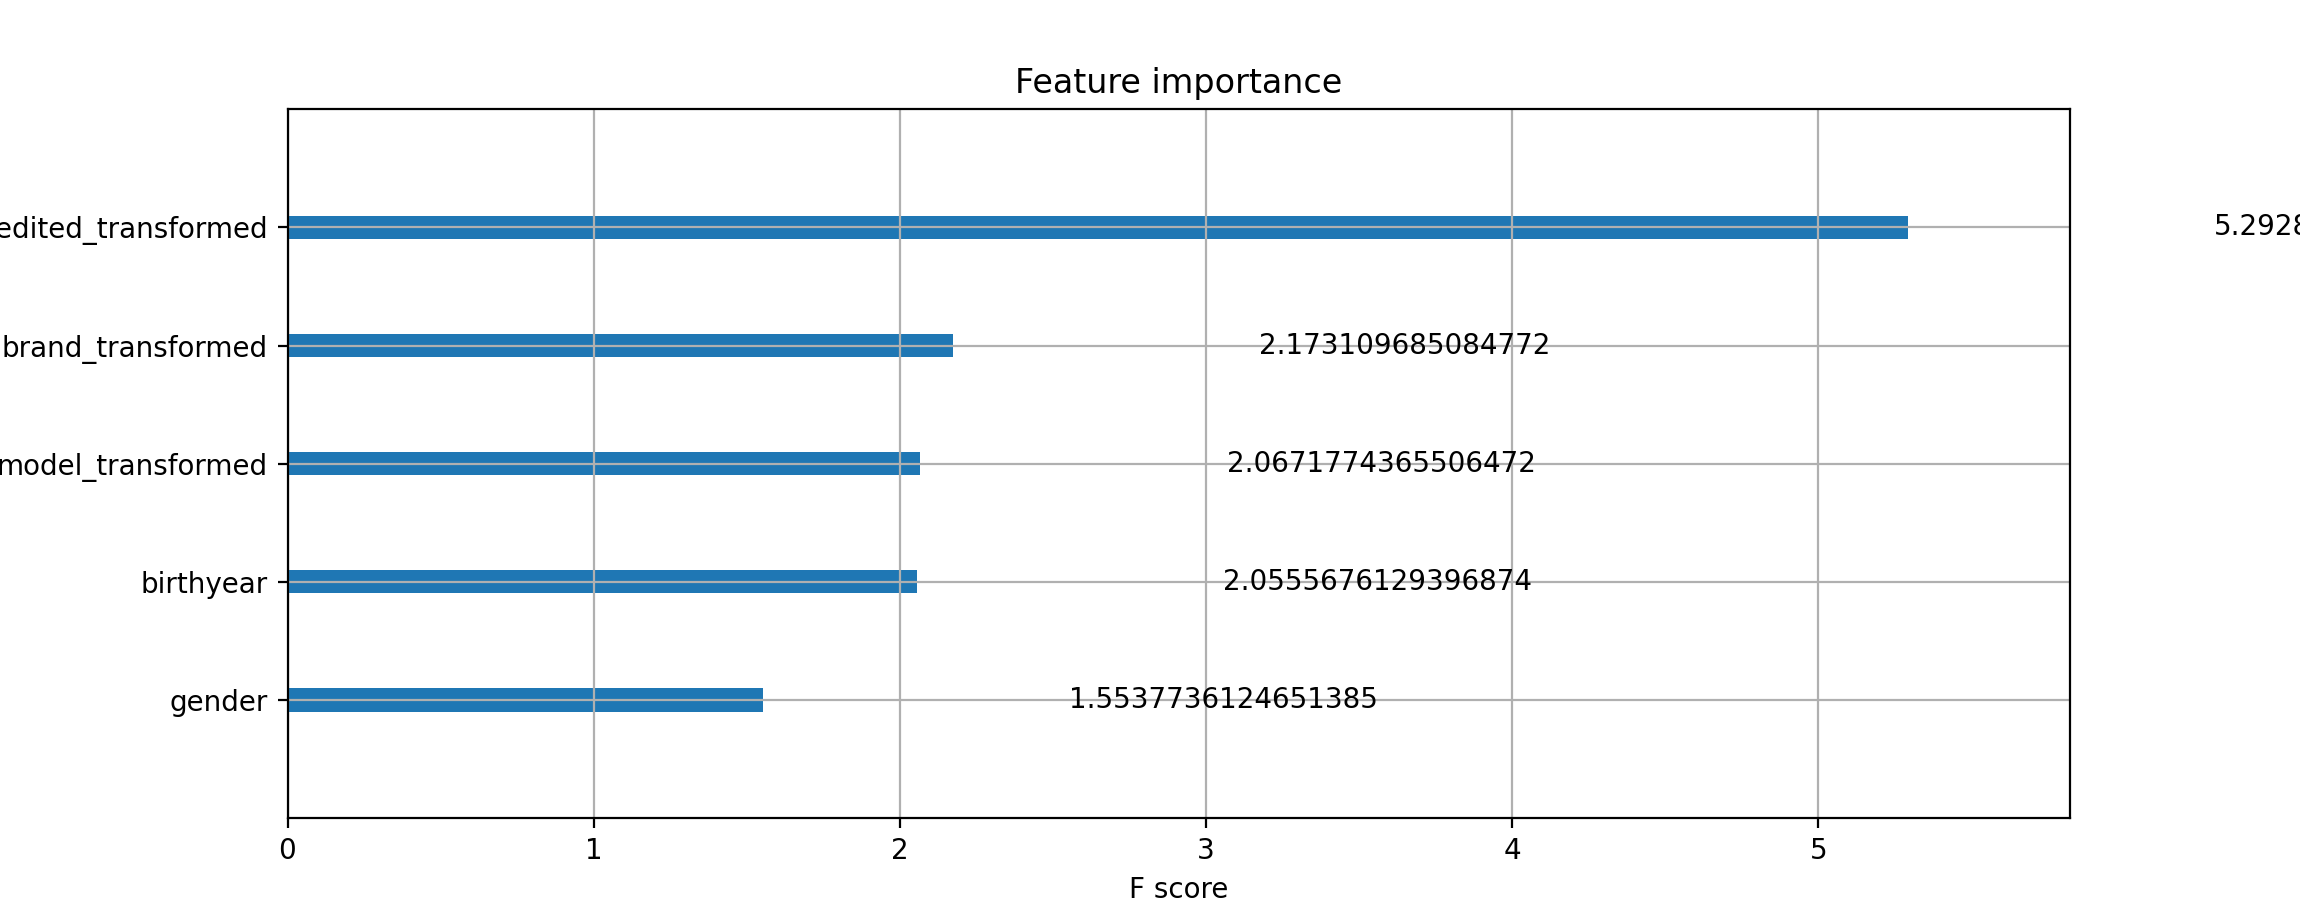

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [500]:
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (5, 2)
plot_importance(model,importance_type='gain')

In [151]:
from hyperopt import fmin, tpe, hp
best = fmin(
    fn=lambda x: x,  # 优化最小化函数
    space=hp.uniform('x', 0, 1),  # x的搜索空间, uniform0-1之间的均匀分布
    algo=tpe.suggest,  # 使用的搜索算法
    max_evals=100)  # 最大评估次数
print(best)

100%|██████████| 100/100 [00:00<00:00, 227.88trial/s, best loss: 0.0002680835084542532]
{'x': 0.0002680835084542532}


In [200]:
col_feat

['gender',
 'birthyear',
 'SOM_OCM_CAREER_transformed',
 'CPL_INDM_EDU_LEVEL_transformed',
 'CPL_INDM_MARRC2_transformed',
 'CPL_INDM_VEIC_VEID_transformed',
 'FIM_FISM_INCL_transformed',
 'FIM_FISM_CONL_CIR_transformed',
 'GBM_BHM_PURB_CONP_transformed',
 'GBM_BHM_PURB_PREF_transformed',
 'DESIRE_House_Rent_transformed',
 'APP_HOBY_BUS_transformed',
 'APP_HOBY_TICKET_transformed',
 'APP_HOBY_TRAIN_transformed',
 'APP_HOBY_FLIGHT_transformed',
 'APP_HOBY_TAXI_transformed',
 'APP_HOBY_SHARE_transformed',
 'sys_ver_edited_transformed',
 'brand_transformed',
 'model_transformed']

In [207]:
# temp['GBM_BHM_PURB_CONP_transformed'].value_counts()

In [350]:
# feature_list
# feature_list_songguo

train_df3[['GBM_BHM_PURB_PREF'+'_transformed','GBM_BHM_PURB_PREF']]

# print(len(train_df3[train_df3.model!='None']))
train_df3[['GBM_BHM_PURB_CONP']].to_csv('BM_BHM_PURB_PREF.csv')

In [348]:
col_feat

['gender',
 'birthyear',
 'SOM_OCM_CAREER_transformed',
 'CPL_INDM_EDU_LEVEL_transformed',
 'CPL_INDM_MARRC2_transformed',
 'CPL_INDM_VEIC_VEID_transformed',
 'FIM_FISM_INCL_transformed',
 'FIM_FISM_CONL_CIR_transformed',
 'GBM_BHM_PURB_CONP_transformed',
 'GBM_BHM_PURB_PREF_transformed',
 'DESIRE_House_Rent_transformed',
 'APP_HOBY_BUS_transformed',
 'APP_HOBY_TICKET_transformed',
 'APP_HOBY_TRAIN_transformed',
 'APP_HOBY_FLIGHT_transformed',
 'APP_HOBY_TAXI_transformed',
 'APP_HOBY_SHARE_transformed',
 'sys_ver_edited_transformed',
 'brand_transformed',
 'model_transformed']

In [353]:
catagories = ["N", "海淘", "拍卖", "包包配饰", "家具家电", "返利返现", "日亚海淘", "图书专卖", "生鲜专卖", "零食专卖", "情趣用品", "化妆品专卖", "二手车交易", "宠物必备", "美妆导购", "母婴玩具", "品牌折扣", "鞋子专卖", "二手闲置", "酒茶专卖", "家装", "代步工具", "珠宝饰品", "奢侈品", "美亚", "服饰专卖", "婚礼筹备", "数码电脑", "户外运动", "二手手机", "网上超市", "免税店", "时尚海淘", "生鲜配送", "数码专卖", "食谱菜谱", "零售百货", "团购特卖", "美甲", "情趣专卖", "收藏品", "药品补品", "虚拟商品", "二次元专卖", "掌上超市", "儿童用品", "酒店用品", "比价", "社交电商", "美食专卖", "汽车专卖", "购物导航", "电影票专卖", "全球导购", "手工艺品", "食品专卖", "海购", "分期购", "信用消费", "二手车", "土特产", "手工制作", "农产品", "优惠券", "批发专卖", "内衣专卖", "特产专卖", "全球美食", "时尚搭配", "品牌特卖", "动漫周边", "卖家版", "校服专卖", "夺宝", "奢饰品", "票务专卖"]
# catagories = list(set(catagories))    # drop duplicate

pd_catagories = pd.get_dummies(pd.Series(catagories))
pd_catagories

,N,二手手机,二手车,二手车交易,二手闲置,二次元专卖,代步工具,优惠券,信用消费,儿童用品,免税店,全球导购,全球美食,内衣专卖,农产品,分期购,动漫周边,包包配饰,化妆品专卖,卖家版,品牌折扣,品牌特卖,团购特卖,图书专卖,土特产,夺宝,奢侈品,奢饰品,婚礼筹备,宠物必备,家具家电,家装,情趣专卖,情趣用品,户外运动,手工制作,手工艺品,批发专卖,拍卖,掌上超市,收藏品,数码专卖,数码电脑,日亚海淘,时尚搭配,时尚海淘,服饰专卖,校服专卖,母婴玩具,比价,汽车专卖,海淘,海购,特产专卖,珠宝饰品,生鲜专卖,生鲜配送,电影票专卖,社交电商,票务专卖,网上超市,美亚,美妆导购,美甲,美食专卖,药品补品,虚拟商品,购物导航,返利返现,酒店用品,酒茶专卖,零售百货,零食专卖,鞋子专卖,食品专卖,食谱菜谱
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [364]:
pd_catagories.loc[[0]]

,N,二手手机,二手车,二手车交易,二手闲置,二次元专卖,代步工具,优惠券,信用消费,儿童用品,免税店,全球导购,全球美食,内衣专卖,农产品,分期购,动漫周边,包包配饰,化妆品专卖,卖家版,品牌折扣,品牌特卖,团购特卖,图书专卖,土特产,夺宝,奢侈品,奢饰品,婚礼筹备,宠物必备,家具家电,家装,情趣专卖,情趣用品,户外运动,手工制作,手工艺品,批发专卖,拍卖,掌上超市,收藏品,数码专卖,数码电脑,日亚海淘,时尚搭配,时尚海淘,服饰专卖,校服专卖,母婴玩具,比价,汽车专卖,海淘,海购,特产专卖,珠宝饰品,生鲜专卖,生鲜配送,电影票专卖,社交电商,票务专卖,网上超市,美亚,美妆导购,美甲,美食专卖,药品补品,虚拟商品,购物导航,返利返现,酒店用品,酒茶专卖,零售百货,零食专卖,鞋子专卖,食品专卖,食谱菜谱
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [366]:
# train_df3[['GBM_BHM_PURB_CONP']]
catagories_set = set()
for row in train_df3['GBM_BHM_PURB_CONP']:
    catagories_set |= set(row.split("、"))
catagories_set.discard("None")
catagories_set.discard("")
# print(catagories_set)
pd_catagories = pd.get_dummies(pd.Series(list(catagories_set)))
pd_catagories.head()

,N,二手手机,二手车,二手车交易,二手闲置,二次元专卖,优惠券,信用消费,儿童用品,免税店,全球导购,全球美食,内衣专卖,农产品,分期购,动漫周边,包包配饰,化妆品专卖,卖家版,品牌折扣,品牌特卖,团购特卖,图书专卖,土特产,奢侈品,婚礼筹备,宠物必备,宠物用品,家具家电,情趣专卖,情趣用品,户外运动,手工制作,手工艺品,批发,批发专卖,折扣优惠,拍卖,捕鱼,掌上超市,收藏品,数码专卖,数码电脑,服饰专卖,母婴玩具,比价,汽车专卖,海外电商,海淘,珠宝饰品,生鲜专卖,生鲜配送,电动车,电影票专卖,社交电商,网上超市,美妆导购,美甲,药品补品,虚拟商品,购物导航,返利返现,返现,返现返利,酒茶专卖,零售百货,零食专卖
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [373]:
pd_catagories = pd.get_dummies(train_df3['GBM_BHM_PURB_CONP'])
train_df3['GBM_BHM_PURB_CONP_one_hot'] = train_df3['GBM_BHM_PURB_CONP'].apply(lambda x: pd_catagories[x].values)

In [374]:
train_df3[['GBM_BHM_PURB_CONP_one_hot']].head()

,GBM_BHM_PURB_CONP_one_hot
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, ..."
2,"[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, ..."
3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [372]:
train_df3[['catagories']].shape

(24298, 1)

In [411]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
# continus_cols = ["APP_HOBY_BUS_transformed", 
#                  "APP_HOBY_TICKET_transformed", 
#                  'APP_HOBY_TRAIN_transformed',
#                  'APP_HOBY_FLIGHT_transformed',
#                  'APP_HOBY_TAXI_transformed',
#                  'APP_HOBY_SHARE_transformed',]

# category_cols = ["gender", "birthyear","SOM_OCM_CAREER_transformed", "CPL_INDM_EDU_LEVEL_transformed",
#                  "CPL_INDM_MARRC2_transformed", "CPL_INDM_VEIC_VEID_transformed",  "GBM_BHM_PURB_CONP_transformed", 
#                  "FIM_FISM_INCL_transformed", "GBM_BHM_PURB_PREF_transformed", 
#                  "DESIRE_House_Rent_transformed",'sys_ver_edited_transformed',
#                 'brand_transformed','model_transformed']
category_cols = ["gender", "birthyear","SOM_OCM_CAREER_transformed", "CPL_INDM_EDU_LEVEL_transformed",
                 "CPL_INDM_MARRC2_transformed", "CPL_INDM_VEIC_VEID_transformed",   
                 "FIM_FISM_INCL_transformed", 
                 'sys_ver_edited_transformed',
                'brand_transformed',
                 'model_transformed']
preprocessor = ColumnTransformer(
                 transformers=[
                    ("onehot", OneHotEncoder(handle_unknown='ignore'), category_cols)
                    ])

train = preprocessor.fit_transform(train_df4[category_cols])
train_y = train_df4[col_label].tolist()



In [383]:
train_df3[continus_cols + category_cols]

,APP_HOBY_BUS_transformed,APP_HOBY_TICKET_transformed,APP_HOBY_TRAIN_transformed,APP_HOBY_FLIGHT_transformed,APP_HOBY_TAXI_transformed,APP_HOBY_SHARE_transformed,gender,birthyear,SOM_OCM_CAREER_transformed,CPL_INDM_EDU_LEVEL_transformed,CPL_INDM_MARRC2_transformed,CPL_INDM_VEIC_VEID_transformed,GBM_BHM_PURB_CONP_transformed,FIM_FISM_INCL_transformed,GBM_BHM_PURB_PREF_transformed,DESIRE_House_Rent_transformed,sys_ver_edited_transformed,brand_transformed,model_transformed
0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,2,1982,4,3,1,0,0,2,61,0,0,12,733
1,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,2,1974,1,0,0,0,1,0,0,0,0,25,510
2,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,2,1997,1,0,0,0,1,0,0,0,0,49,812
3,0.0000,0.0,0.7618,0.0000,0.0000,0.0000,2,1977,4,1,1,0,2010,0,61,0,0,49,821
4,0.0000,0.0,0.0000,0.0000,0.0258,0.1786,2,1998,18,3,2,0,227,2,61,0,7,49,775
5,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,1,1973,4,2,2,0,1,1,61,0,6,25,498
6,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,2,2000,1,0,0,0,1,0,0,0,5,49,913
8,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,1,1993,1,0,0,0,1,0,0,0,3,25,471
9,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,1,1991,1,0,0,0,1,0,0,0,7,44,401
11,0.0000,0.0,0.0000,0.0000,0.0001,0.0000,2,1998,7,1,1,0,3323,2,61,0,0,11,165


In [412]:
def hyperopt_objective(params):
    
#     model = xgb(
#         max_depth=int(params['max_depth']) + 3,
#         eta=params['eta'],
#         reg_lambda=params['reg_lambda'],
#         min_child_weight=int(params['min_child_weight']),
#         subsample=params["subsample"],
#         colsample_bytree=params["colsample_bytree"],
#         gamma=params["gamma"]
    model = XGBClassifier(
        objective= 'binary:logistic',
        max_depth=int(params['max_depth']) + 3,
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        min_child_weight=int(params['min_child_weight']),
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
#         gamma=params["gamma"]
#         reg_lambda=params['reg_lambda']
    )
     
    res = np.mean(cross_val_score(model, train, train_y, cv=5, n_jobs=-1, scoring='roc_auc'))
    print("*" * 30)
    print(params)
    print("roc_auc: {}".format(res))
    
    return 1 - res
params_space = {
#     'max_depth': hyperopt.hp.randint('max_depth', 12),
#     'eta': hyperopt.hp.uniform('eta', 1e-3, 5e-1),
#     'reg_lambda': hyperopt.hp.uniform("reg_lambda", 1, 10),
#     'min_child_weight': hyperopt.hp.randint('min_child_weight', 3),
#     'subsample': hyperopt.hp.uniform('subsample', 0.6, 1),
#     'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.6, 1),
#     'gamma': hyperopt.hp.uniform('gamma', 0, 0.3)
    'max_depth': hyperopt.hp.randint('max_depth',3, 12),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 3e-1),
    'n_estimators': hyperopt.hp.quniform("n_estimators", 100, 200, 20),
    'min_child_weight': hyperopt.hp.randint('min_child_weight', 3),
    'subsample': hyperopt.hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.6, 1),
#     'gamma': hyperopt.hp.uniform('gamma', 0, 0.3)
}
trials = hyperopt.Trials()
best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=20,
    trials=trials)

print("最佳参数")
print(best)

******************************                        
{'colsample_bytree': 0.7663014165540989, 'learning_rate': 0.019164917796233423, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 140.0, 'subsample': 0.7473534692610398}
roc_auc: 0.5737036541283882                           
******************************                                                  
{'colsample_bytree': 0.895601897974249, 'learning_rate': 0.12818815921722018, 'max_depth': 8, 'min_child_weight': 0, 'n_estimators': 140.0, 'subsample': 0.7647815455784095}
roc_auc: 0.5615743398643414                                                     
******************************                                                  
{'colsample_bytree': 0.7376732766822194, 'learning_rate': 0.14599661479503456, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 160.0, 'subsample': 0.9700116861998492}
roc_auc: 0.5615129180454318                                                     
******************************              

In [291]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

temp = train_df3

col_feat = col_feat

col_ans = 'pref'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

for train_index, test_index in kf.split(temp):
    f+=1
    train1 = temp.iloc[train_index]
    test1 = temp.iloc[test_index]
    
    X = train1[col_feat]
    y = train1[col_ans]
    
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'gamma': 0.2060473136255449,
        'max_depth': 1,
        'lambda': 3,
        'subsample': 0.8597082491860872,
        'colsample_bytree': 0.6995209833991581,
        'min_child_weight': 1,
        'eta': 0.040028177709372656,
        'seed': 1000,
        'nthread': 4,
        'n_estimators': 160.0
    }

    dtrain = xgb.DMatrix(X, y)
    num_rounds = 100
    plst = params.items()
    model = XGBClassifier()
    dtest = xgb.DMatrix(test1[col_feat])
    model.fit(X, y, early_stopping_rounds=20, eval_metric=["auc",'error'], eval_set=[(test1[col_feat],test1[col_ans].astype('int'))], verbose=True)
    pred = model.predict(test1[col_feat])
    pred = [round(value) for value in pred]
    
    accuracy = accuracy_score(test1[col_ans].astype('int'), pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))




[0]	validation_0-auc:0.54209	validation_0-error:0.31029
Multiple eval metrics have been passed: 'validation_0-error' will be used for early stopping.

Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-auc:0.55784	validation_0-error:0.31173
[2]	validation_0-auc:0.54577	validation_0-error:0.31296
[3]	validation_0-auc:0.53926	validation_0-error:0.31173
[4]	validation_0-auc:0.53510	validation_0-error:0.31029
[5]	validation_0-auc:0.53511	validation_0-error:0.31029
[6]	validation_0-auc:0.53098	validation_0-error:0.30988
[7]	validation_0-auc:0.52866	validation_0-error:0.30885
[8]	validation_0-auc:0.52754	validation_0-error:0.30823
[9]	validation_0-auc:0.52656	validation_0-error:0.30844
[10]	validation_0-auc:0.52583	validation_0-error:0.30988
[11]	validation_0-auc:0.52623	validation_0-error:0.30967
[12]	validation_0-auc:0.52553	validation_0-error:0.31029
[13]	validation_0-auc:0.52299	validation_0-error:0.31111
[14]	validation_0-auc:0.52189	validation_0-error:0.

[14]	validation_0-auc:0.51221	validation_0-error:0.30829
[15]	validation_0-auc:0.51022	validation_0-error:0.30788
[16]	validation_0-auc:0.51118	validation_0-error:0.30768
[17]	validation_0-auc:0.51115	validation_0-error:0.30850
[18]	validation_0-auc:0.50984	validation_0-error:0.30891
[19]	validation_0-auc:0.51160	validation_0-error:0.30932
[20]	validation_0-auc:0.50966	validation_0-error:0.30953
[21]	validation_0-auc:0.50896	validation_0-error:0.31015
[22]	validation_0-auc:0.51023	validation_0-error:0.30994
[23]	validation_0-auc:0.51070	validation_0-error:0.30932
[24]	validation_0-auc:0.51070	validation_0-error:0.30932
[25]	validation_0-auc:0.51024	validation_0-error:0.30932
Stopping. Best iteration:
[5]	validation_0-auc:0.52050	validation_0-error:0.30500

Accuracy: 69.50%


In [262]:
# continus_cols = ["APP_HOBY_BUS_transformed", 
#                  "APP_HOBY_TICKET_transformed", 
#                  'APP_HOBY_TRAIN_transformed',
#                  'APP_HOBY_FLIGHT_transformed',
#                  'APP_HOBY_TAXI_transformed',
#                  'APP_HOBY_SHARE_transformed',]


In [278]:
train_df3[train_df3.APP_HOBY_SHARE!='None'].APP_HOBY_SHARE.map(lambda x:eval(x[5:]))

4        0.1786
18       0.1806
27       0.1860
32       0.1512
37       0.2195
51       0.1846
86       0.1847
96       0.9970
169      0.9955
190      0.1632
198      0.2501
276      0.1058
323      0.9993
344      0.1856
373      0.1601
376      0.1718
393      0.9180
400      0.1025
411      0.1414
433      0.1701
440      0.9998
456      0.9962
468      0.9945
476      0.4921
511      0.1535
530      0.8480
541      0.5313
559      0.5521
561      0.9194
564      0.1735
586      0.7945
587      0.2202
598      0.2980
634      0.1764
656      0.9982
671      0.1664
683      0.3345
689      0.9924
711      0.4018
729      0.9905
748      0.9959
756      0.1485
777      0.1346
780      0.1406
791      0.9937
809      0.9998
817      0.1312
827      0.1032
849      0.9925
866      0.1996
          ...  
29496    0.5372
29498    0.9961
29501    0.1046
29507    0.1618
29528    0.1936
29537    0.1290
29556    0.1405
29558    0.6175
29569    0.1445
29579    0.1856
29583    0.1077
29589   

In [277]:
train_df3[train_df3.APP_HOBY_TAXI!='None'][['APP_HOBY_TAXI']]

,APP_HOBY_TAXI
4,打车&0.0258
11,打车&0.0001
18,打车&0.0001
27,打车&0.0001
32,打车&0.0001
37,打车&0.0001
51,打车&0.1248
86,打车&0.0001
96,打车&0.0001
169,打车&0.0258


In [217]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

temp = train_df3

col_feat = col_feat

col_ans = 'pref'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

for train_index, test_index in kf.split(temp):
    f+=1
    train = temp.iloc[train_index]
    test = temp.iloc[test_index]
    
    X = train[col_feat]
    y = train[col_ans]
    
    params = {
        'booster': 'gbtree',
        'objective': 'reg:gamma',
        'gamma': 0.1,
        'max_depth': 6,
        'lambda': 3,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'min_child_weight': 1,
        'eta': 0.1,
        'seed': 1000,
        'nthread': 4,
    }

    dtrain = xgb.DMatrix(X, y)
    num_rounds = 100
    plst = params.items()
    model = XGBClassifier()
    dtest = xgb.DMatrix(test[col_feat])
    model.fit(X, y, early_stopping_rounds=20, eval_metric="logloss", eval_set=[(test[col_feat],test[col_ans].astype('int'))], verbose=True)
    pred = model.predict(test[col_feat])
    pred = [round(value) for value in pred]
    accuracy = accuracy_score(test[col_ans].astype('int'), pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	validation_0-logloss:0.65386
Will train until validation_0-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.63470
[2]	validation_0-logloss:0.62516
[3]	validation_0-logloss:0.62050
[4]	validation_0-logloss:0.61862
[5]	validation_0-logloss:0.61733
[6]	validation_0-logloss:0.61707
[7]	validation_0-logloss:0.61698
[8]	validation_0-logloss:0.61699
[9]	validation_0-logloss:0.61713
[10]	validation_0-logloss:0.61784
[11]	validation_0-logloss:0.61831
[12]	validation_0-logloss:0.61823
[13]	validation_0-logloss:0.61894
[14]	validation_0-logloss:0.61949
[15]	validation_0-logloss:0.61990
[16]	validation_0-logloss:0.61996
[17]	validation_0-logloss:0.62009
[18]	validation_0-logloss:0.62099
[19]	validation_0-logloss:0.62136
[20]	validation_0-logloss:0.62189
[21]	validation_0-logloss:0.62183
[22]	validation_0-logloss:0.62234
[23]	validation_0-logloss:0.62255
[24]	validation_0-logloss:0.62265
[25]	validation_0-logloss:0.62313
[26]	validation_0-logloss:0.62339
[27]	validation_0-loglos